# Methylation trends in EB days 0-6

### initialize definitions

In [1]:
suppressMessages(suppressWarnings(source(here::here("code/init.R"))))

### Load data

Load the data of methylation day 0-4:

In [2]:
cpg_meth <- calc_eb_day0_to_day4_cpg_meth(min_cov = 10, max_na  = 5)

In [3]:
m <- intervs_to_mat(cpg_meth)

In [4]:
dim(m)

[1] 132052     24

In [5]:
colnames(m)

[1] "d0_3a"   "d0S_3a"  "d1_3a"   "d2_3a"   "d3_3a"   "d4_3a"   "d0_3b"  
 [8] "d0S_3b"  "d1_3b"   "d2_3b"   "d3_3b"   "d4_3b"   "d0_tko"  "d0S_tko"
[15] "d1_tko"  "d2_tko"  "d3_tko"  "d4_tko"  "d0_wt"   "d0S_wt"  "d1_wt"  
[22] "d2_wt"   "d3_wt"   "d4_wt"

### Cluster

In [6]:
colnames(m)
m_column_order <- c(
    "d0_3a", "d1_3a", "d2_3a", "d3_3a", "d4_3a",
    "d0_3b", "d1_3b", "d2_3b", "d3_3b", "d4_3b",
    "d0_wt", "d1_wt", "d2_wt", "d3_wt", "d4_wt",    
    "d0_tko", "d1_tko", "d2_tko", "d3_tko", "d4_tko",
    "d0S_3a", "d0S_3b", "d0S_wt", "d0S_tko"
)
m <- m[, m_column_order]
colnames(m)

[1] "d0_3a"   "d0S_3a"  "d1_3a"   "d2_3a"   "d3_3a"   "d4_3a"   "d0_3b"  
 [8] "d0S_3b"  "d1_3b"   "d2_3b"   "d3_3b"   "d4_3b"   "d0_tko"  "d0S_tko"
[15] "d1_tko"  "d2_tko"  "d3_tko"  "d4_tko"  "d0_wt"   "d0S_wt"  "d1_wt"  
[22] "d2_wt"   "d3_wt"   "d4_wt"

[1] "d0_3a"   "d1_3a"   "d2_3a"   "d3_3a"   "d4_3a"   "d0_3b"   "d1_3b"  
 [8] "d2_3b"   "d3_3b"   "d4_3b"   "d0_wt"   "d1_wt"   "d2_wt"   "d3_wt"  
[15] "d4_wt"   "d0_tko"  "d1_tko"  "d2_tko"  "d3_tko"  "d4_tko"  "d0S_3a" 
[22] "d0S_3b"  "d0S_wt"  "d0S_tko"

In [7]:
K <- 60
km <- tglkmeans::TGL_kmeans(m, K, id_column=FALSE, seed=19) %cache_rds% here("output/meth_capt_clust.rds")

In [8]:
enframe(km$size[c(1, 9, 19, 24, 30, 32, 40, 44, 53, 60)])

name,value
<chr>,<int>
1,1179
9,5459
19,2023
24,1573
30,1295
32,2810
40,1837
44,1755
53,1606


In [9]:
km_m_3a <- rowSums(km$centers[,c("d1_3a","d2_3a","d3_3a","d4_3a")])
km_m_3b <- rowSums(km$centers[,c("d1_3b","d2_3b","d3_3b","d4_3b")])
km_m_wt <- rowSums(km$centers[,c("d1_wt","d2_wt","d3_wt","d4_wt")])
cent_dlt <- km$centers[,c("d1_3a","d2_3a","d3_3a","d4_3a")]-
km$centers[,c("d1_3b","d2_3b","d3_3b","d4_3b")]

In [10]:
dlt24 <- cent_dlt[,2]-cent_dlt[,4]

clst_mod <- rep(0, K)
clst_mod[(km_m_3a-km_m_3b) < -0.3 & dlt24 > -0.05] <- 3
clst_mod[(km_m_3a-km_m_3b) < -0.2 & dlt24 < -0.05] <- 2
clst_mod[(km_m_3a-km_m_3b) > 0.2] <- 1

In [11]:
smooth_n = floor(nrow(m)/1000)+1
km_mean_e = rowSums(km$centers)
tot_cent_dlt = rowSums(cent_dlt)

k_ord = order(ifelse(clst_mod==0, 
                    km_mean_e, 
                    abs(tot_cent_dlt)) + clst_mod*20)
clst_map <- 1:K
names(clst_map) <- as.character(k_ord)
clst <- km$cluster
clst_sorted <- clst_map[as.character(clst)]
km$cluster <- clst_sorted
km$centers <- km$centers[k_ord,]
rownames(km$centers) <- 1:K
m_ord <- order(km$cluster)

In [12]:
m_s5 = apply(m[m_ord,-1],2, zoo::rollmean, smooth_n, fill=c('extend',NA,'extend'), na.rm=T)

colnames(m_s5) = colnames(m)[-1]

In [13]:
dim(m_s5)

[1] 132052     23

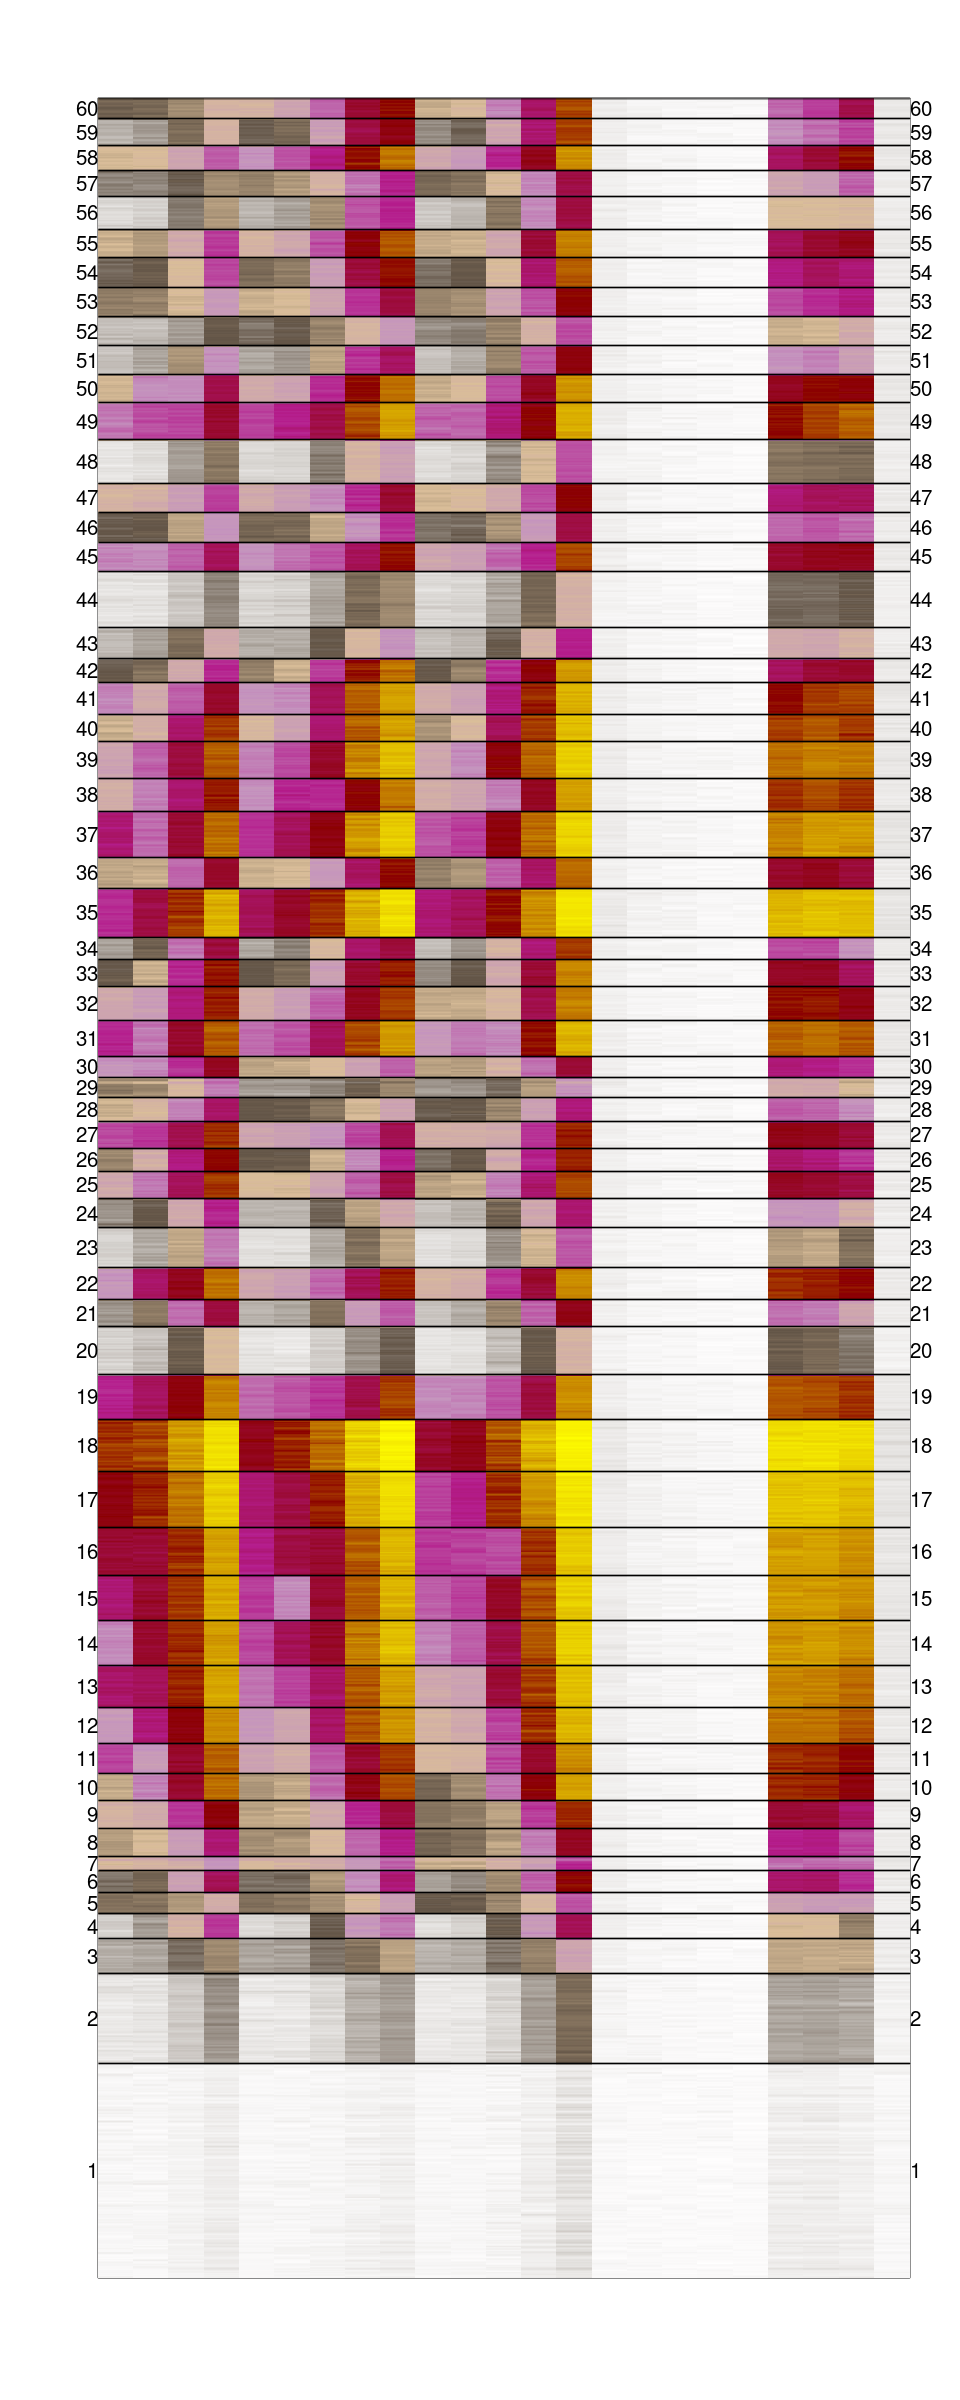

In [14]:
options(repr.plot.width = 8, repr.plot.height = 20)
plot_clust <- function() {
    shades <- colorRampPalette(c("white", "#635547", "#DABE99","#C594BF","#B51D8D","darkred", "yellow"))(1000)
    image(t(as.matrix(m_s5)),col=shades, xaxt='n', yaxt='n'); 
    N = length(m_ord)

    m_y = tapply((1:N)/N, km$cluster[m_ord], mean)
    mtext(1:K, at = m_y, las=2, side= 2)
    mtext(1:K, at = m_y, las=2, side= 4)
    abline(h=tapply((1:N)/N, km$cluster[m_ord], max))
}
plot_clust()

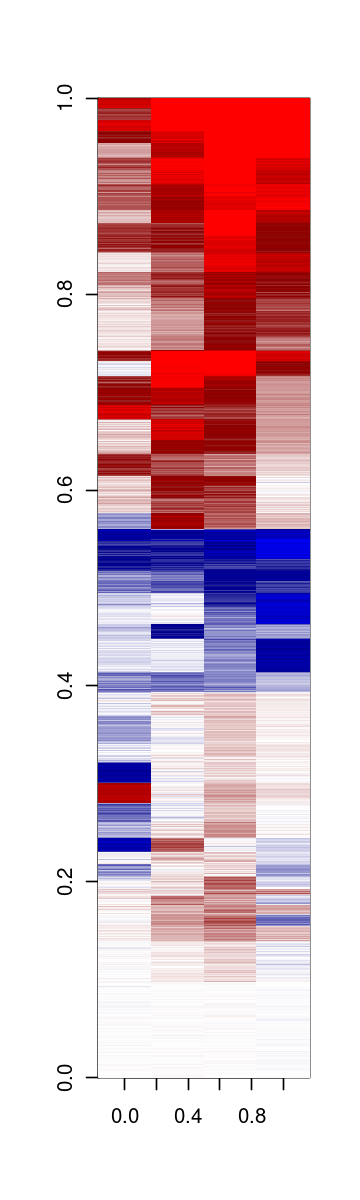

In [15]:
options(repr.plot.width = 3, repr.plot.height = 10)
plot_delta <- function(){
    delta = m_s5[,c("d1_3a","d2_3a","d3_3a","d4_3a")]-
            m_s5[,c("d1_3b","d2_3b","d3_3b","d4_3b")]

    dshades <- colorRampPalette(c("red","darkred","white","darkblue","blue"))(1000)
    image(pmin(pmax(t(as.matrix(delta)),-0.3),0.3),col=dshades,zlim=c(-0.3,0.3))
}
plot_delta()

### Project DNMT1 data

In [16]:
clust_intervs <- m %>% mat_to_intervs() %>% select(chrom:end)

In [17]:
all_clust_data <- calc_eb_cpg_meth(from = 0, to = 5, min_cov = 10, max_na = NULL, intervals = clust_intervs, iterator = clust_intervs, cache_fn = here("output/all_clust_data.tsv"), rm_meth_cov = TRUE)

In [18]:
colnames(all_clust_data)

[1] "chrom"     "start"     "end"       "d0_d13ako" "d3_d13ako" "d4_d13ako"
 [7] "d0_d13bko" "d3_d13bko" "d4_d13bko" "d5_dko"    "d0_ko1"    "d0S_ko1"  
[13] "d1_ko1"    "d2_ko1"    "d3_ko1"    "d4_ko1"    "d5_ko1"    "d0_3a"    
[19] "d0S_3a"    "d1_3a"     "d2_3a"     "d3_3a"     "d4_3a"     "d5_3a"    
[25] "d0_3b"     "d0S_3b"    "d1_3b"     "d2_3b"     "d3_3b"     "d4_3b"    
[31] "d5_3b"     "d0_tko"    "d0S_tko"   "d1_tko"    "d2_tko"    "d3_tko"   
[37] "d4_tko"    "d0_wt"     "d0S_wt"    "d1_wt"     "d2_wt"     "d3_wt"    
[43] "d4_wt"     "d5_wt"

In [19]:
m_column_order <- c(
    "d0_3a", "d1_3a", "d2_3a", "d3_3a", "d4_3a", 
    "d0_3b", "d1_3b", "d2_3b", "d3_3b", "d4_3b", 
    "d0_wt", "d1_wt", "d2_wt", "d3_wt", "d4_wt", 
    "d0_tko", "d1_tko", "d2_tko", "d3_tko", "d4_tko",
    "d0S_3a", "d0S_3b", "d0S_wt", "d0S_tko", "d0S_ko1",
    "d0_ko1", "d1_ko1", "d2_ko1", "d3_ko1", "d4_ko1", 
    "d0_d13ako", "d3_d13ako", "d4_d13ako",
    "d0_d13bko", "d3_d13bko", "d4_d13bko"
)
setdiff(colnames(all_clust_data)[-1:-3], m_column_order)

[1] "d5_dko" "d5_ko1" "d5_3a"  "d5_3b"  "d5_wt"

In [20]:
m_all <- intervs_to_mat(all_clust_data)[, m_column_order]
colnames(m_all)

[1] "d0_3a"     "d1_3a"     "d2_3a"     "d3_3a"     "d4_3a"     "d0_3b"    
 [7] "d1_3b"     "d2_3b"     "d3_3b"     "d4_3b"     "d0_wt"     "d1_wt"    
[13] "d2_wt"     "d3_wt"     "d4_wt"     "d0_tko"    "d1_tko"    "d2_tko"   
[19] "d3_tko"    "d4_tko"    "d0S_3a"    "d0S_3b"    "d0S_wt"    "d0S_tko"  
[25] "d0S_ko1"   "d0_ko1"    "d1_ko1"    "d2_ko1"    "d3_ko1"    "d4_ko1"   
[31] "d0_d13ako" "d3_d13ako" "d4_d13ako" "d0_d13bko" "d3_d13bko" "d4_d13bko"

In [21]:
m_all_s5 = apply(m_all[m_ord, ],2, zoo::rollmean, smooth_n, fill=c('extend',NA,'extend'), na.rm=T)

In [22]:
head(m_all_s5)

d0_3a,d1_3a,d2_3a,d3_3a,d4_3a,d0_3b,d1_3b,d2_3b,d3_3b,d4_3b,⋯,d1_ko1,d2_ko1,d3_ko1,d4_ko1,d0_d13ako,d3_d13ako,d4_d13ako,d0_d13bko,d3_d13bko,d4_d13bko
0.01001037,0.01079793,0.004898041,0.01102023,0.01277668,0.005717633,0.007146658,0.008921023,0.01298582,0.01649393,⋯,0.006723765,0.007574284,0.01410948,0.007942855,0.008525676,0.0166642,0.01150588,0.006178614,0.01029716,0.005339577
0.01001037,0.01079793,0.004898041,0.01102023,0.01277668,0.005717633,0.007146658,0.008921023,0.01298582,0.01649393,⋯,0.006723765,0.007574284,0.01410948,0.007942855,0.008525676,0.0166642,0.01150588,0.006178614,0.01029716,0.005339577
0.01001037,0.01079793,0.004898041,0.01102023,0.01277668,0.005717633,0.007146658,0.008921023,0.01298582,0.01649393,⋯,0.006723765,0.007574284,0.01410948,0.007942855,0.008525676,0.0166642,0.01150588,0.006178614,0.01029716,0.005339577
0.01001037,0.01079793,0.004898041,0.01102023,0.01277668,0.005717633,0.007146658,0.008921023,0.01298582,0.01649393,⋯,0.006723765,0.007574284,0.01410948,0.007942855,0.008525676,0.0166642,0.01150588,0.006178614,0.01029716,0.005339577
0.01001037,0.01079793,0.004898041,0.01102023,0.01277668,0.005717633,0.007146658,0.008921023,0.01298582,0.01649393,⋯,0.006723765,0.007574284,0.01410948,0.007942855,0.008525676,0.0166642,0.01150588,0.006178614,0.01029716,0.005339577
0.01001037,0.01079793,0.004898041,0.01102023,0.01277668,0.005717633,0.007146658,0.008921023,0.01298582,0.01649393,⋯,0.006723765,0.007574284,0.01410948,0.007942855,0.008525676,0.0166642,0.01150588,0.006178614,0.01029716,0.005339577


In [23]:
days <- strsplit(colnames(m_all_s5), split = "_") %>% map_chr(~ .x[1]) %>% gsub("d", "", .) 
days[grep("0S", days)] <- c("A", "B", "WT", "TKO", "KO1")

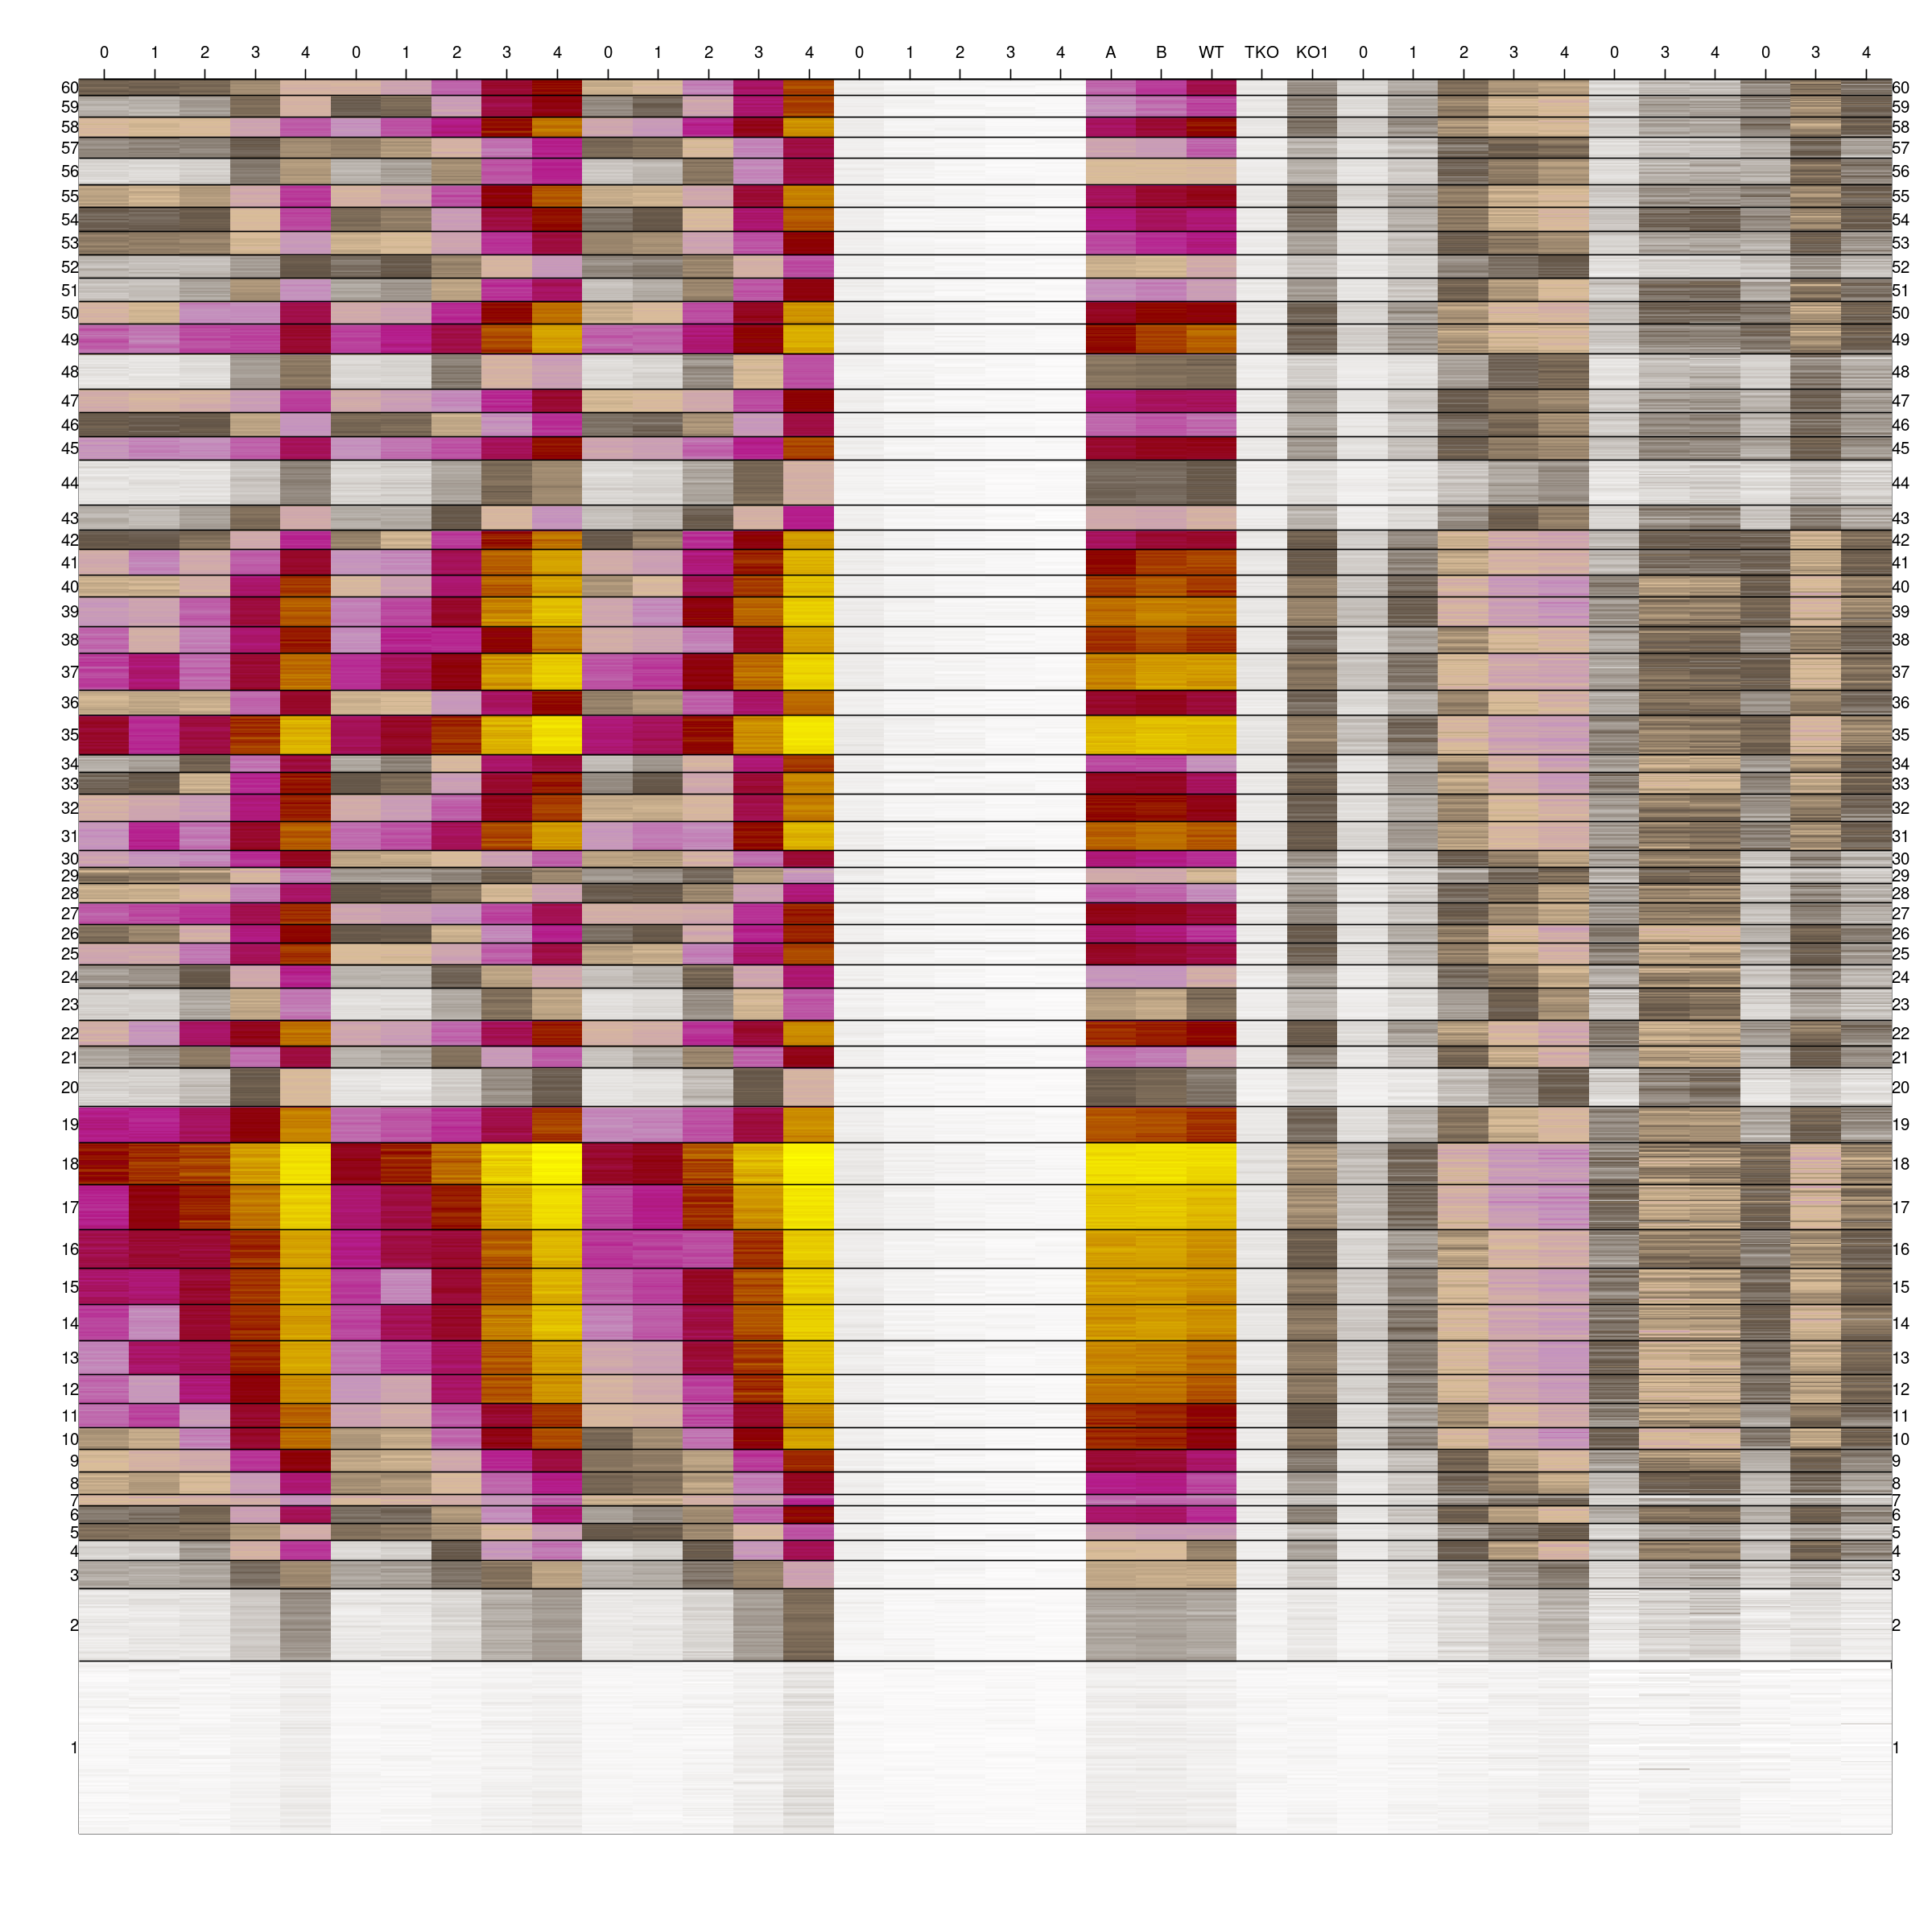

In [24]:
options(repr.plot.width = 20, repr.plot.height = 20)
shades <- colorRampPalette(c("white", "#635547", "#DABE99","#C594BF","#B51D8D","darkred", "yellow"))(1000)
image(t(as.matrix(m_all_s5)),col=shades, xaxt='n', yaxt='n'); 
N = length(m_ord)

m_y = tapply((1:N)/N, km$cluster[m_ord], mean)
mtext(1:K, at = m_y, las=2, side= 2)
mtext(1:K, at = m_y, las=2, side= 4)
axis(3, at = seq(0, 1, length = ncol(m_all_s5)), labels = days)
abline(h=tapply((1:N)/N, km$cluster[m_ord], max))

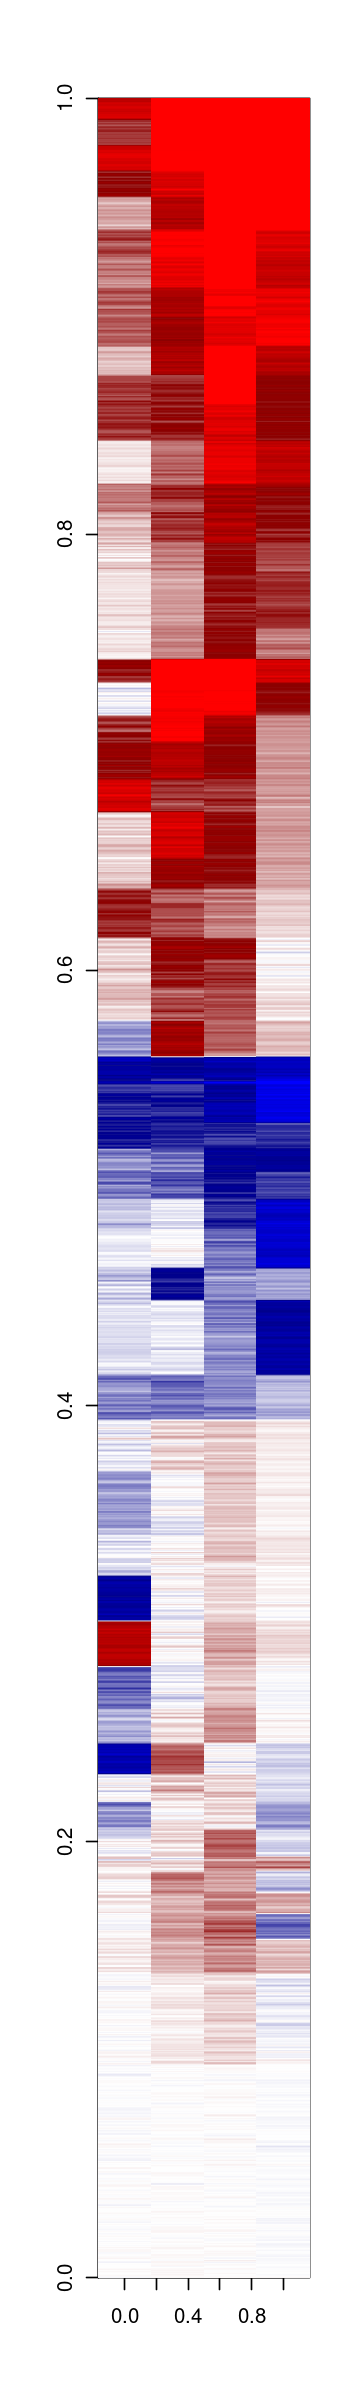

In [25]:
options(repr.plot.width = 3, repr.plot.height = 20)
delta = m_s5[,c("d1_3a","d2_3a","d3_3a","d4_3a")]-
        m_s5[,c("d1_3b","d2_3b","d3_3b","d4_3b")]

dshades <- colorRampPalette(c("red","darkred","white","darkblue","blue"))(1000)
image(pmin(pmax(t(as.matrix(delta)),-0.3),0.3),col=dshades,zlim=c(-0.3,0.3))

#### Trajectory per cluster

In [26]:
chosen_clusters <- c(1, 9, 19, 24, 30, 32, 40, 44, 53, 60)

In [27]:
line_colors <- c("wt" = "darkblue", "3a" = "purple", "3b" = "orange", "tko" = "darkgray", "ko1" = "darkgreen", "d13ako" = "turquoise4", "d13bko" = "orangered4")

In [28]:
df <- all_clust_data %>%         
    mutate(clust = km$cluster) %>% 
    group_by(clust) %>% 
    summarise_at(vars(starts_with("d")), mean, na.rm=TRUE) %>% 
    gather("samp", "meth", -clust) %>% 
    separate(samp, c("day", "line"), sep="_") %>% 
    filter(day != "d0S", day != "d5") %>% 
    mutate(day = gsub("d", "", day)) %>% 
    mutate(line = factor(line, levels = names(line_colors)))

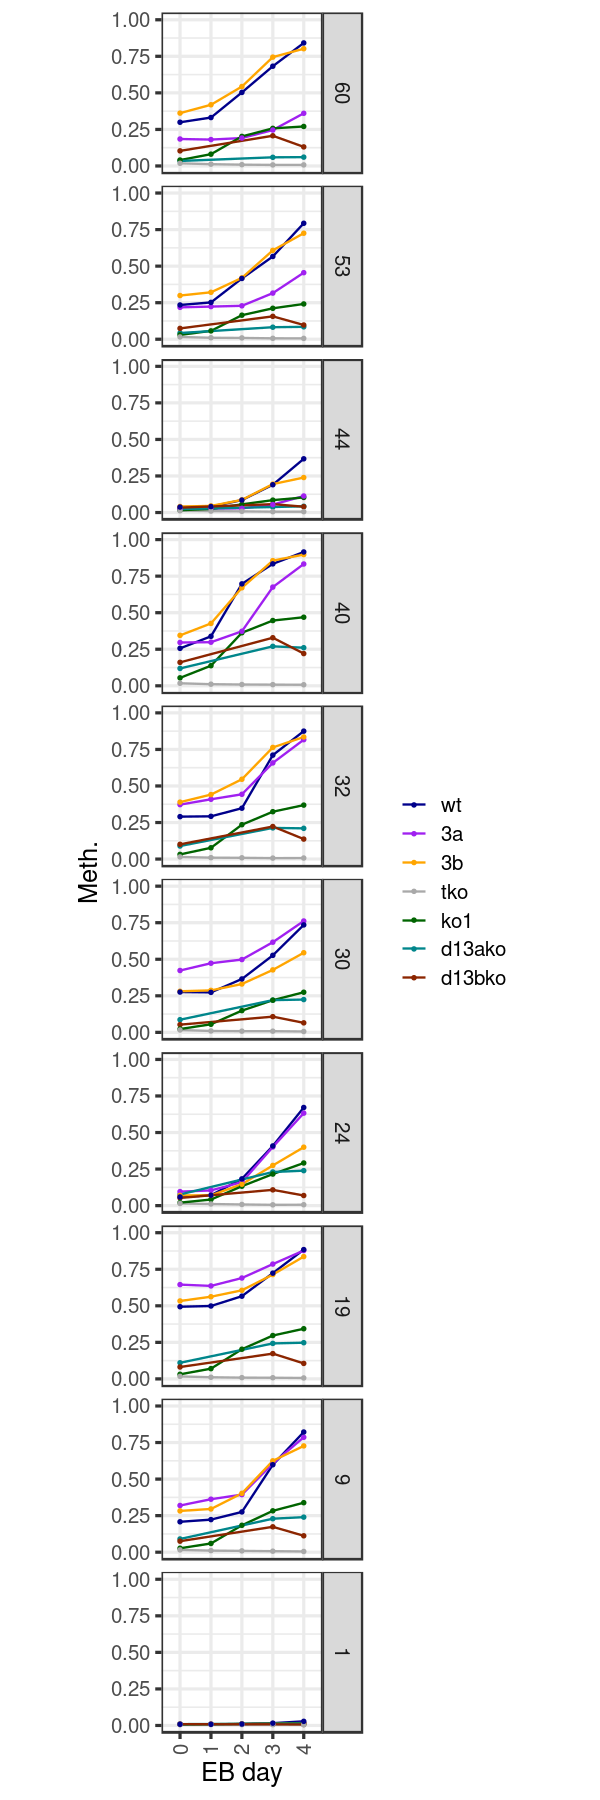

In [29]:
options(repr.plot.width = 5, repr.plot.height = 15)
df %>% 
    filter(clust %in% chosen_clusters) %>% 
    mutate(clust = factor(clust), clust = forcats::fct_rev(clust)) %>% 
    ggplot(aes(x=day, y=meth, color=line, group=line)) + 
        geom_line() + 
        geom_point(size=0.5) + 
        xlab("EB day") + 
        ylab("Meth.") + 
        theme(aspect.ratio = 1) + 
        facet_grid(clust~.) + 
        scale_color_manual(name = "", values = line_colors) + 
        scale_y_continuous(limits=c(0,1))

## Plot global EB trends

### Figure 4A

In [30]:
cpg_meth1 <- gextract.left_join("seq.CG_500_mean", intervals=cpg_meth, iterator=cpg_meth, colnames="cg_cont") %>% select(-(chrom1:end1)) %>% select(chrom, start, end, cg_cont, everything()) %>% as_tibble()

In [31]:
line_colors <- c("wt" = "darkblue", "3a" = "purple", "3b" = "orange", "tko" = "darkgray")
df <- cpg_meth1 %>% 
    mutate(cg_cont = cut(cg_cont, c(0,0.03,0.08,0.15), include.lowest=TRUE, labels=c("low", "mid", "high"))) %>% 
    group_by(cg_cont) %>% 
    summarise_at(vars(starts_with("d")), mean, na.rm=TRUE) %>% 
    gather("samp", "meth", -cg_cont) %>% 
    separate(samp, c("day", "line"), sep="_") %>% 
    filter(day != "d0S") %>% 
    mutate(day = gsub("d", "", day)) %>% 
    mutate(line = factor(line, levels = names(line_colors)))

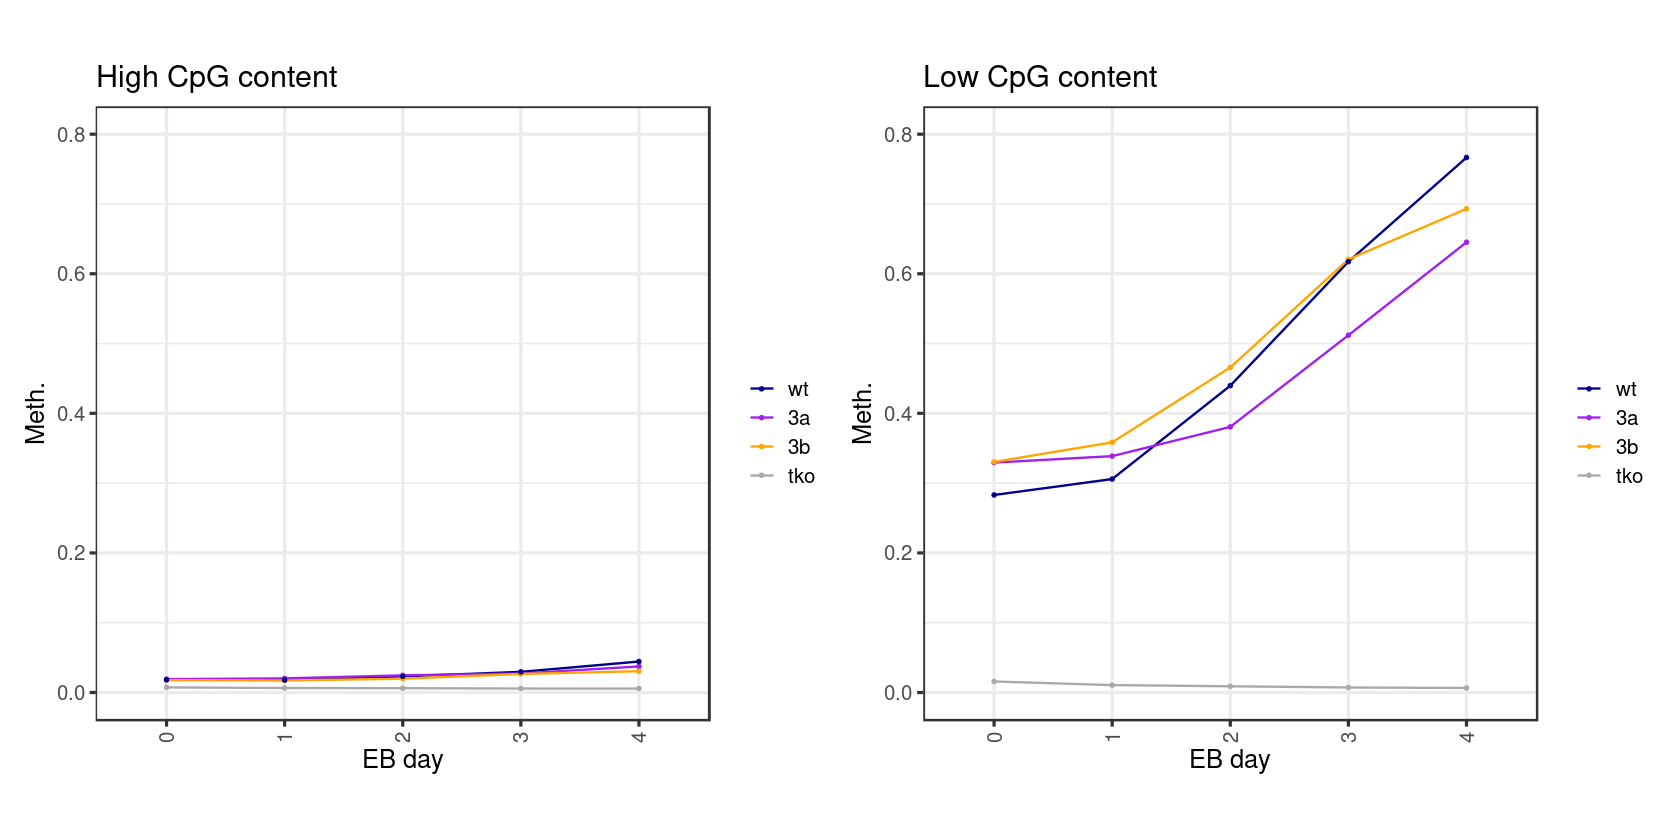

In [32]:
options(repr.plot.width = 14, repr.plot.height = 7)
p_high <- df %>% filter(cg_cont == "high") %>% ggplot(aes(x=day, y=meth, color=line, group=line)) + geom_line() + geom_point(size=0.5) + ggtitle("High CpG content") + xlab("EB day") + ylab("Meth.") + theme(aspect.ratio = 1) + scale_color_manual(name = "", values = line_colors) + scale_y_continuous(limits=c(0,0.8))
p_low <- df %>% filter(cg_cont == "low") %>% ggplot(aes(x=day, y=meth, color=line, group=line)) + geom_line() + geom_point(size=0.5) + ggtitle("Low CpG content") + xlab("EB day") + ylab("Meth.") + theme(aspect.ratio = 1) + scale_color_manual(name = "", values = line_colors) + scale_y_continuous(limits=c(0,0.8))
p_high + p_low

### Extended Data Figure 8K

Same for X chromosome

In [33]:
line_colors <- c("wt" = "darkblue", "3a" = "purple", "3b" = "orange", "tko" = "darkgray")
df <- cpg_meth1 %>% 
    mutate(type = case_when(chrom == "chrX" ~ "X", TRUE ~ "autosome")) %>% 
    mutate(cg_cont = cut(cg_cont, c(0,0.03,0.08,0.15), include.lowest=TRUE, labels=c("low", "mid", "high"))) %>% 
    group_by(type, cg_cont) %>% 
    summarise_at(vars(starts_with("d")), mean, na.rm=TRUE) %>% 
    gather("samp", "meth", -cg_cont, -type) %>% 
    separate(samp, c("day", "line"), sep="_") %>% 
    filter(day != "d0S") %>% 
    mutate(day = gsub("d", "", day)) %>% 
    mutate(line = factor(line, levels = names(line_colors)))

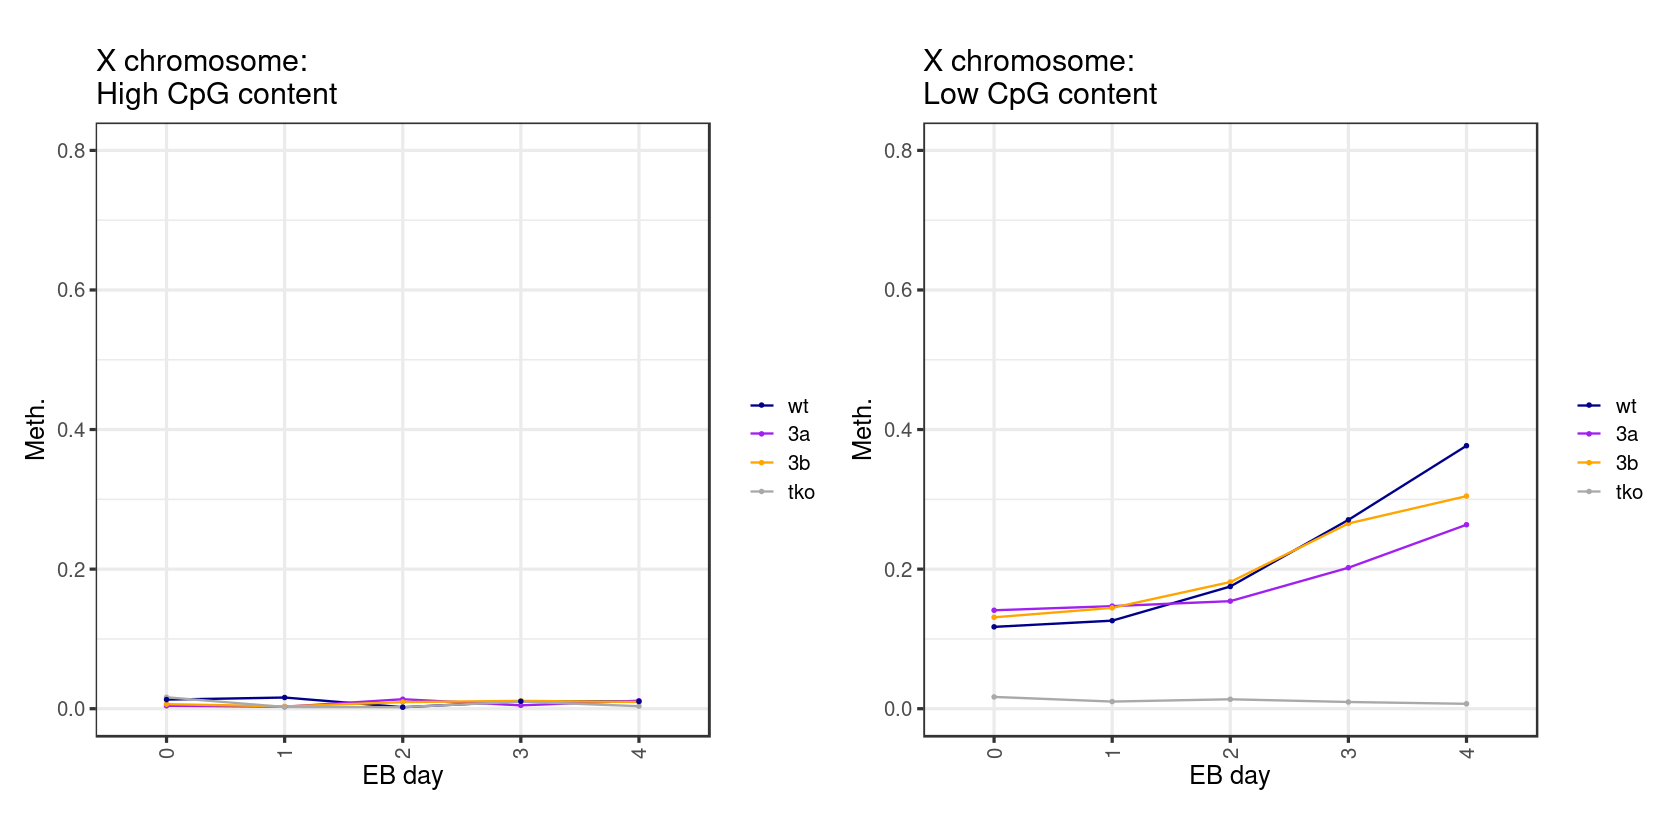

In [34]:
options(repr.plot.width = 14, repr.plot.height = 7)
p_high_x <- df %>% filter(type == "X", cg_cont == "high") %>% ggplot(aes(x=day, y=meth, color=line, group=line)) + geom_line() + geom_point(size=0.5) + ggtitle("X chromosome:\nHigh CpG content") + xlab("EB day") + ylab("Meth.") + theme(aspect.ratio = 1) + scale_color_manual(name = "", values = line_colors) + scale_y_continuous(limits=c(0,0.8))
p_low_x <- df %>% filter(type == "X", cg_cont == "low") %>% ggplot(aes(x=day, y=meth, color=line, group=line)) + geom_line() + geom_point(size=0.5) + ggtitle("X chromosome:\nLow CpG content") + xlab("EB day") + ylab("Meth.") + theme(aspect.ratio = 1) + scale_color_manual(name = "", values = line_colors) + scale_y_continuous(limits=c(0,0.8))
p_high_x + p_low_x

## cluster methylation in days 5 and 6 with DKO

In [35]:
cpg_meth_56 <- calc_eb_day5_to_day6_cpg_meth()

### Project DKO on day 1-4 clusters

In [36]:
all_clust_data <- calc_eb_cpg_meth(from = 0, to = 6, min_cov = 10, max_na = NULL, intervals = clust_intervs, iterator = clust_intervs, cache_fn = here("output/all_clust_data_day1_to_6.tsv"), rm_meth_cov = TRUE, tracks_key = NULL)

In [37]:
m_column_order <- c(
    "d0_3a", "d1_3a", "d2_3a", "d3_3a", "d4_3a",  "d5_3a", "d6_3a", 
    "d0_3b", "d1_3b", "d2_3b", "d3_3b", "d4_3b",  "d5_3b", "d6_3b",
    "d0_wt", "d1_wt", "d2_wt", "d3_wt", "d4_wt",  "d5_wt", "d6_wt",
    "d5_dko", "d6_dko",
    "d0_tko", "d1_tko", "d2_tko", "d3_tko", "d4_tko", 
    "d0S_3a", "d0S_3b", "d0S_wt", "d0S_tko"
)
setdiff(colnames(all_clust_data)[-1:-3], m_column_order)

[1] "d0_d13ako" "d3_d13ako" "d4_d13ako" "d0_d13bko" "d3_d13bko" "d4_d13bko"
 [7] "d0_ko1"    "d0S_ko1"   "d1_ko1"    "d2_ko1"    "d3_ko1"    "d4_ko1"   
[13] "d5_ko1"

In [38]:
setdiff(m_column_order, colnames(all_clust_data))

character(0)

In [39]:
m_all <- intervs_to_mat(all_clust_data)[, m_column_order]
colnames(m_all)

[1] "d0_3a"   "d1_3a"   "d2_3a"   "d3_3a"   "d4_3a"   "d5_3a"   "d6_3a"  
 [8] "d0_3b"   "d1_3b"   "d2_3b"   "d3_3b"   "d4_3b"   "d5_3b"   "d6_3b"  
[15] "d0_wt"   "d1_wt"   "d2_wt"   "d3_wt"   "d4_wt"   "d5_wt"   "d6_wt"  
[22] "d5_dko"  "d6_dko"  "d0_tko"  "d1_tko"  "d2_tko"  "d3_tko"  "d4_tko" 
[29] "d0S_3a"  "d0S_3b"  "d0S_wt"  "d0S_tko"

In [40]:
m_all_s5 = apply(m_all[m_ord, ],2, zoo::rollmean, smooth_n, fill=c('extend',NA,'extend'), na.rm=T)

In [41]:
head(m_all_s5)

d0_3a,d1_3a,d2_3a,d3_3a,d4_3a,d5_3a,d6_3a,d0_3b,d1_3b,d2_3b,⋯,d6_dko,d0_tko,d1_tko,d2_tko,d3_tko,d4_tko,d0S_3a,d0S_3b,d0S_wt,d0S_tko
0.01001037,0.01079793,0.004898041,0.01102023,0.01277668,0,0.02408283,0.005717633,0.007146658,0.008921023,⋯,0.004717813,0.005965149,0.004823037,0.004019872,0.005696785,0.006240729,0.01627394,0.01726621,0.02124627,0.007268556
0.01001037,0.01079793,0.004898041,0.01102023,0.01277668,0,0.02408283,0.005717633,0.007146658,0.008921023,⋯,0.004717813,0.005965149,0.004823037,0.004019872,0.005696785,0.006240729,0.01627394,0.01726621,0.02124627,0.007268556
0.01001037,0.01079793,0.004898041,0.01102023,0.01277668,0,0.02408283,0.005717633,0.007146658,0.008921023,⋯,0.004717813,0.005965149,0.004823037,0.004019872,0.005696785,0.006240729,0.01627394,0.01726621,0.02124627,0.007268556
0.01001037,0.01079793,0.004898041,0.01102023,0.01277668,0,0.02408283,0.005717633,0.007146658,0.008921023,⋯,0.004717813,0.005965149,0.004823037,0.004019872,0.005696785,0.006240729,0.01627394,0.01726621,0.02124627,0.007268556
0.01001037,0.01079793,0.004898041,0.01102023,0.01277668,0,0.02408283,0.005717633,0.007146658,0.008921023,⋯,0.004717813,0.005965149,0.004823037,0.004019872,0.005696785,0.006240729,0.01627394,0.01726621,0.02124627,0.007268556
0.01001037,0.01079793,0.004898041,0.01102023,0.01277668,0,0.02408283,0.005717633,0.007146658,0.008921023,⋯,0.004717813,0.005965149,0.004823037,0.004019872,0.005696785,0.006240729,0.01627394,0.01726621,0.02124627,0.007268556


In [42]:
days <- strsplit(colnames(m_all_s5), split = "_") %>% map_chr(~ .x[1]) %>% gsub("d", "", .)
days

[1] "0"  "1"  "2"  "3"  "4"  "5"  "6"  "0"  "1"  "2"  "3"  "4"  "5"  "6"  "0" 
[16] "1"  "2"  "3"  "4"  "5"  "6"  "5"  "6"  "0"  "1"  "2"  "3"  "4"  "0S" "0S"
[31] "0S" "0S"

In [43]:
days[grep("0S", days)] <- c("A", "B", "WT", "TKO")

### Figure 4C

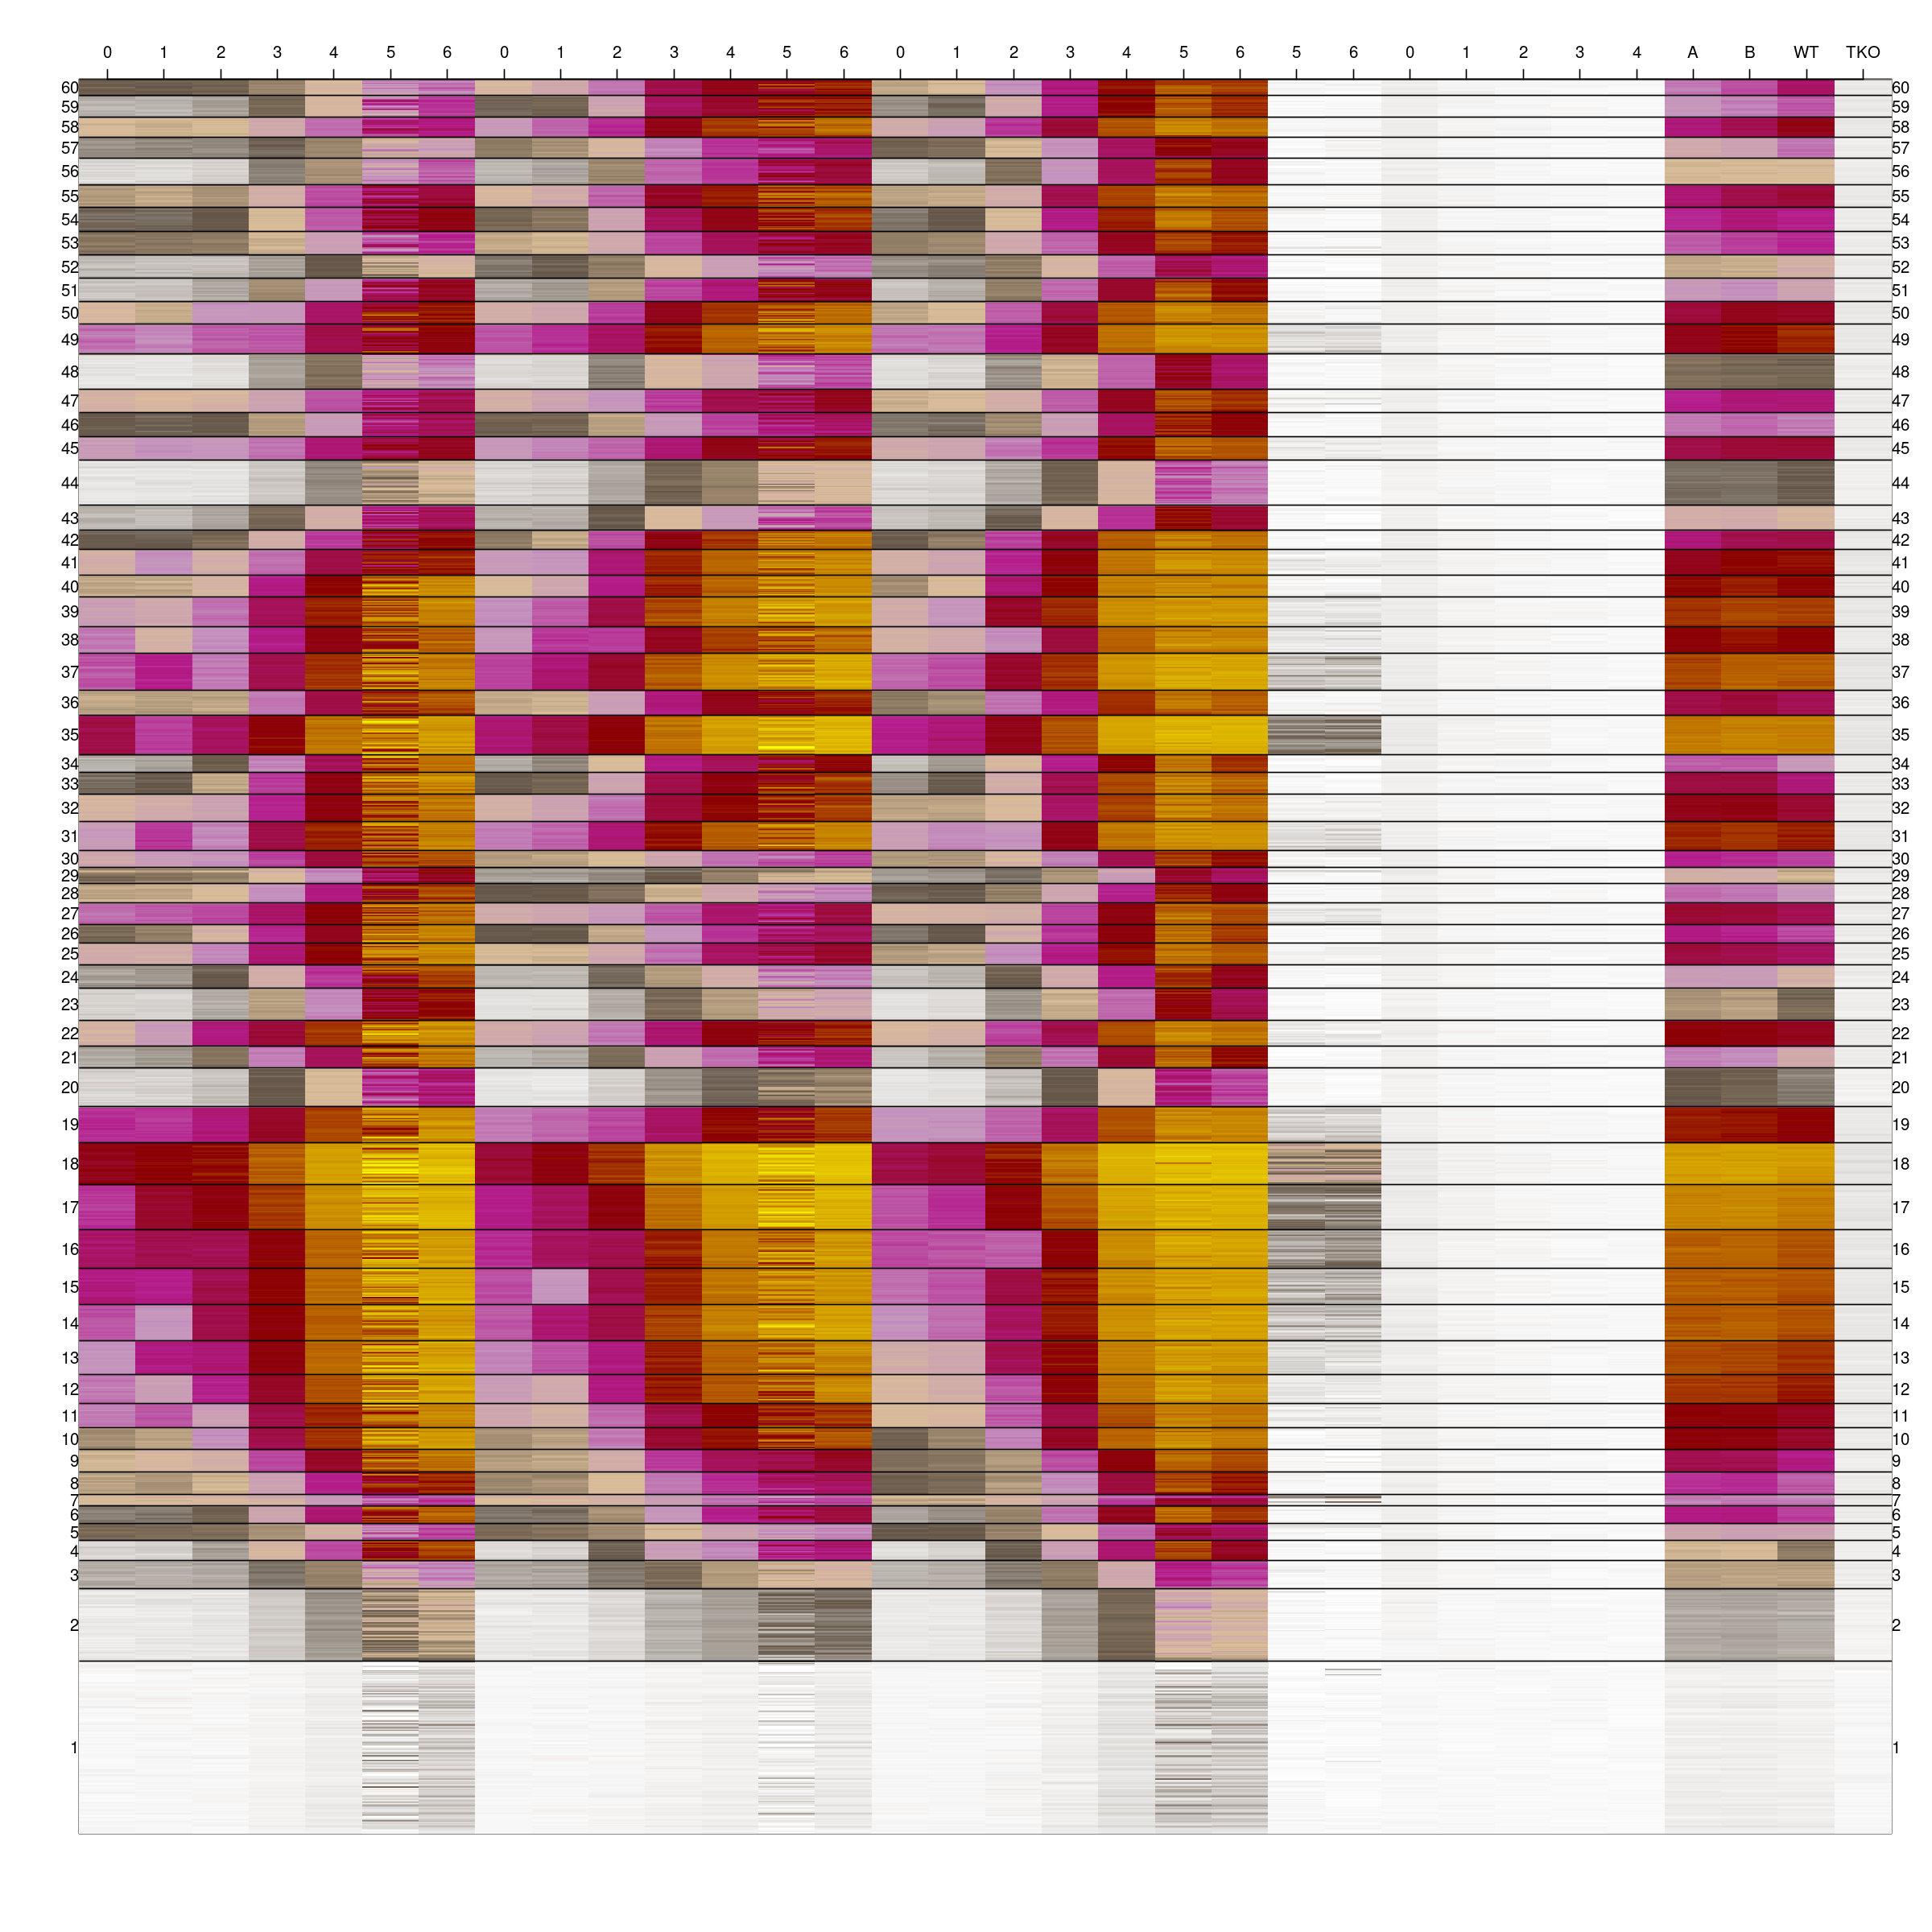

In [44]:
options(repr.plot.width = 20, repr.plot.height = 20)
shades <- colorRampPalette(c("white", "#635547", "#DABE99","#C594BF","#B51D8D","darkred", "yellow"))(1000)
image(t(as.matrix(m_all_s5)),col=shades, xaxt='n', yaxt='n'); 
N = length(m_ord)

m_y = tapply((1:N)/N, km$cluster[m_ord], mean)
mtext(1:K, at = m_y, las=2, side= 2)
mtext(1:K, at = m_y, las=2, side= 4)
axis(3, at = seq(0, 1, length = ncol(m_all_s5)), labels = days)
abline(h=tapply((1:N)/N, km$cluster[m_ord], max))

### Figure 4B

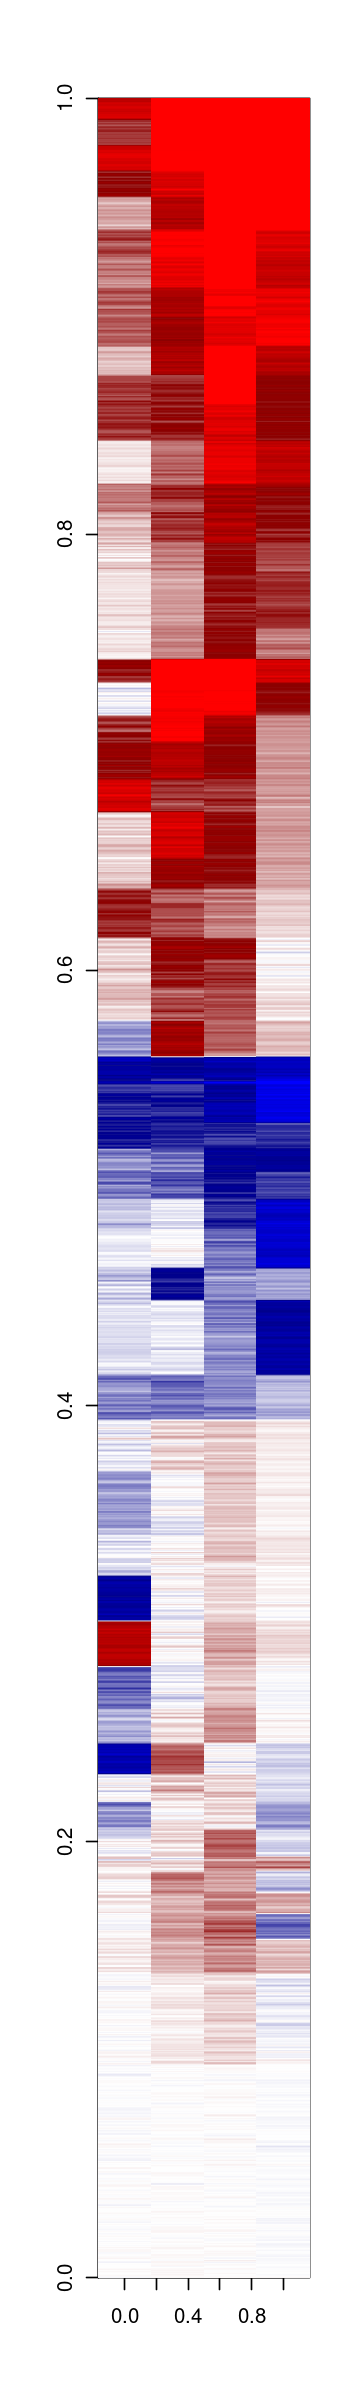

In [45]:
options(repr.plot.width = 3, repr.plot.height = 20)
delta = m_s5[,c("d1_3a","d2_3a","d3_3a","d4_3a")]-
        m_s5[,c("d1_3b","d2_3b","d3_3b","d4_3b")]

dshades <- colorRampPalette(c("red","darkred","white","darkblue","blue"))(1000)
image(pmin(pmax(t(as.matrix(delta)),-0.3),0.3),col=dshades,zlim=c(-0.3,0.3))